In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

In [ ]:
import random

class JellyFishOptimizer:
    def __init__(self, fitness_func, dim, pop_size=20, max_iter=50):
        self.fitness_func = fitness_func
        self.dim = dim
        self.pop_size = pop_size
        self.max_iter = max_iter

    def optimize(self):
        population = np.random.randint(0, 2, size=(self.pop_size, self.dim))
        best_sol = None
        best_fit = float('-inf')

        for iter in range(self.max_iter):
            for i in range(self.pop_size):
                fitness = self.fitness_func(population[i])
                if fitness > best_fit:
                    best_fit = fitness
                    best_sol = population[i].copy()

            for i in range(self.pop_size):
                r = random.random()
                rand_idx = np.random.randint(self.pop_size)
                movement = population[rand_idx] - population[i]
                if r < 0.5:
                    population[i] = population[i] + movement
                else:
                    population[i] = population[i] - movement

                population[i] = np.clip(population[i], 0, 1)

            population = np.where(np.random.rand(*population.shape) < 0.5, 1, 0)  

        return best_sol

df = pd.read_excel(r"C:\Users\kumar\Desktop\dataset\processed.cleveland.data.xlsx")

df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')


df.dropna(inplace=True)


X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
y = (y > 0).astype(int) 
y = (y > 0).astype(int)  


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


def fitness_function(mask):
    if np.count_nonzero(mask) == 0:
        return 0
    X_sel = X_scaled[:, mask == 1]
    X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    return accuracy_score(y_test, pred)





In [10]:
print(df.columns)

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


In [12]:
pd.set_option('display.max_rows', None)

print(df)

      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
5    56.0  1.0  2.0     120.0  236.0  0.0      0.0    178.0    0.0      0.8   
6    62.0  0.0  4.0     140.0  268.0  0.0      2.0    160.0    0.0      3.6   
7    57.0  0.0  4.0     120.0  354.0  0.0      0.0    163.0    1.0      0.6   
8    63.0  1.0  4.0     130.0  254.0  0.0      2.0    147.0    0.0      1.4   
9    53.0  1.0  4.0     140.0  203.0  1.0      2.0    155.0    1.0      3.1   
10   57.0  1.0  4.0     140.0  192.0  0.0      0.0    148.0    0.0      0.4   
11   56.0  0.0  2.0     140.0  294.0  0.0      2.0  

In [3]:
jfo = JellyFishOptimizer(fitness_func=fitness_function, dim=X.shape[1], pop_size=30, max_iter=30)
best_features = jfo.optimize()
print("Selected Features Mask:", best_features)


X_selected = X_scaled[:, best_features == 1]


X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)


xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_auc = roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1])


lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)
lgb_auc = roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1])


def get_metrics(y_true, y_pred, y_prob):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) * 100
    specificity = tn / (tn + fp) * 100
    accuracy = accuracy_score(y_true, y_pred) * 100
    auc = roc_auc_score(y_true, y_prob) * 100
    return sensitivity, specificity, accuracy, auc

xgb_metrics = get_metrics(y_test, xgb_pred, xgb_model.predict_proba(X_test)[:,1])
lgb_metrics = get_metrics(y_test, lgb_pred, lgb_model.predict_proba(X_test)[:,1])


print("\nXGBoost with JF Selected Features:")
print("Sensitivity: %.2f%% | Specificity: %.2f%% | Accuracy: %.2f%% | AUC: %.2f%%" % xgb_metrics)

print("\nLightGBM with JF Selected Features:")
print("Sensitivity: %.2f%% | Specificity: %.2f%% | Accuracy: %.2f%% | AUC: %.2f%%" % lgb_metrics)


Selected Features Mask: [1 1 1 0 0 0 1 0 1 1 1 1 1]
[LightGBM] [Info] Number of positive: 113, number of negative: 124
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 237, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476793 -> initscore=-0.092894
[LightGBM] [Info] Start training from score -0.092894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


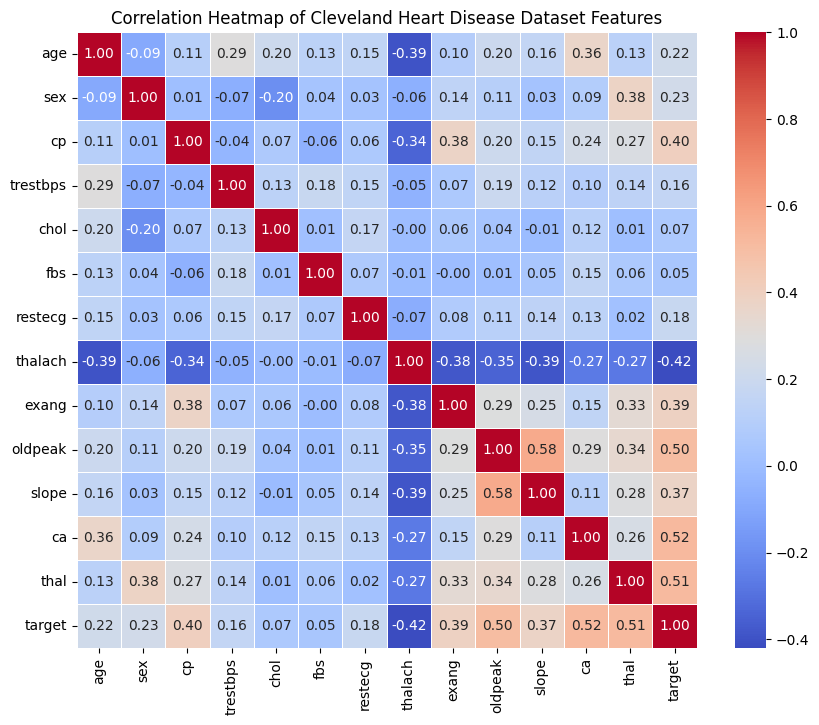

In [4]:
data = pd.read_excel(r"C:\Users\kumar\Desktop\dataset\processed.cleveland.data.xlsx")
data.replace('?', pd.NA, inplace=True)
data.dropna(inplace=True)
correlation_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Cleveland Heart Disease Dataset Features')
plt.show()

In [5]:

lgb = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42)
param_grid = {
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [-1, 3, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 500],
    'min_data_in_leaf': [10, 20, 30, 50],
    'lambda_l1': [0, 0.1, 0.5, 1],
    'lambda_l2': [0, 0.1, 0.5, 1],
    'feature_fraction': [0.7, 0.8, 0.9, 1.0],
    'bagging_fraction': [0.7, 0.8, 0.9, 1.0],
    'bagging_freq': [0, 2, 5, 10]
}
rand_search = RandomizedSearchCV(
    estimator=lgb,
    param_distributions=param_grid,
    n_iter=50,              
    scoring='roc_auc',      
    cv=5,                  
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rand_search.fit(X_selected, y)
print("✅ Best Parameters:\n", rand_search.best_params_)
print("\n📈 Best AUC Score: {:.4f}".format(rand_search.best_score_))


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] l

In [6]:
best_lgb_model = rand_search.best_estimator_
y_pred = best_lgb_model.predict(X_selected)
y_proba = best_lgb_model.predict_proba(X_selected)[:, 1]
cm = confusion_matrix(y, y_pred)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) * 100
specificity = tn / (tn + fp) * 100
accuracy = accuracy_score(y, y_pred) * 100
auc = roc_auc_score(y, y_proba) * 100
print("📊 Confusion Matrix:\n", cm)
print(f"\n✅ Sensitivity (Recall): {sensitivity:.2f}%")
print(f"✅ Specificity: {specificity:.2f}%")
print(f"✅ Accuracy: {accuracy:.2f}%")
print(f"✅ AUC Score: {auc:.2f}%")
print("\n🧾 Classification Report:\n", classification_report(y, y_pred))


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current valu

c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [7]:
from lightgbm import LGBMClassifier
final_model = LGBMClassifier(
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.05, 
    n_estimators=100
)
final_model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 113, number of negative: 124
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 237, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.476793 -> initscore=-0.092894
[LightGBM] [Info] Start training from score -0.092894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(learning_rate=0.05)

In [9]:
probs = final_model.predict_proba(X_test)[:,1]
best_acc, best_thr = 0, 0.5
for thr in np.linspace(0.3, 0.7, 41):
    preds = (probs >= thr).astype(int)
    acc_thr = accuracy_score(y_test, preds)
    if acc_thr > best_acc:
        best_acc, best_thr = acc_thr, thr
print(f"Best threshold: {best_thr:.2f} → Accuracy: {best_acc*100:.2f}%")


Best threshold: 0.36 → Accuracy: 90.00%


c:\Users\kumar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
